# Prob　給与予測
## 目的

以下のデータから、その人物の給与を予測する
1. position
2. age
3. area
4. sex
5. partner
6. num_child
7. education
8. service_length
9. study_time
10. commute
11. overtime

In [13]:
import os
import platform 
import gc

import re
import numpy as np
import pandas as pd

pd.options.display.max_columns = None
pd.options.display.max_rows = None

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

import lightgbm as lgb

import warnings 
warnings.filterwarnings('ignore')

In [14]:
print(platform.system())
if platform.system() == 'Darwin':
    path = "/Users/betashort/Google Drive/Prediction_Salary/"
elif platform.system() == 'Windows':
    path = "C://Users/ail11208/Google ドライブ/SIGNATE_mynavi2019/"

Darwin


# input

In [15]:
X = pd.read_csv('input/train_data.csv')
X_test = pd.read_csv('input/test_data.csv')

# 目的変数 - salary

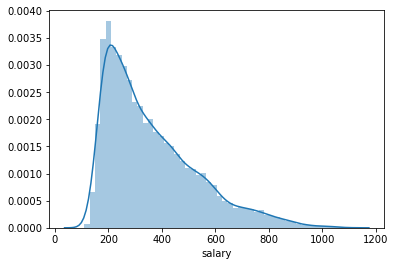

In [16]:
sns.distplot(X['salary']);

## 対数変換してみる

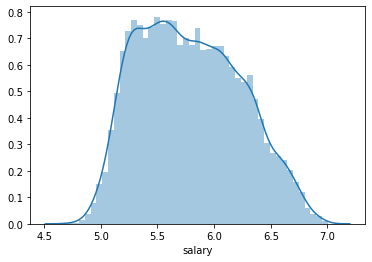

In [17]:
sns.distplot(np.log(X['salary']));

# データについて

In [18]:
X.describe()

,id,position,age,sex,partner,num_child,education,service_length,study_time,commute,overtime,salary
count,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000
mean,10499.500000,1.226857,33.132476,1.498333,0.499333,0.999667,1.098571,12.303143,3.828476,1.059910,12.126752,361.170391
std,6062.322162,1.224682,10.715241,0.500009,0.500011,1.417459,1.116355,10.696823,3.312927,0.665307,5.509408,171.618501
min,0.000000,0.000000,18.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,110.622310
25%,5249.750000,0.000000,24.000000,1.000000,0.000000,0.000000,0.000000,3.000000,1.000000,0.500000,8.300000,225.498117
50%,10499.500000,1.000000,30.000000,1.000000,0.000000,0.000000,1.000000,9.000000,3.000000,1.100000,12.100000,315.224583
75%,15749.250000,2.000000,42.000000,2.000000,1.000000,2.000000,2.000000,21.000000,6.000000,1.500000,15.800000,456.927443
max,20999.000000,4.000000,67.000000,2.000000,1.000000,9.000000,4.000000,49.000000,24.000000,4.800000,31.900000,1098.943632


<img src='./image/description.png'>

# 欠測値
欠測値は無い

In [19]:
X.isnull().sum()

id                0
position          0
age               0
area              0
sex               0
partner           0
num_child         0
education         0
service_length    0
study_time        0
commute           0
overtime          0
salary            0
dtype: int64

In [20]:
X_test.isnull().sum()

id                0
position          0
age               0
area              0
sex               0
partner           0
num_child         0
education         0
service_length    0
study_time        0
commute           0
overtime          0
dtype: int64

In [21]:
X.dtypes

id                  int64
position            int64
age                 int64
area               object
sex                 int64
partner             int64
num_child           int64
education           int64
service_length      int64
study_time        float64
commute           float64
overtime          float64
salary            float64
dtype: object

# 相関係数

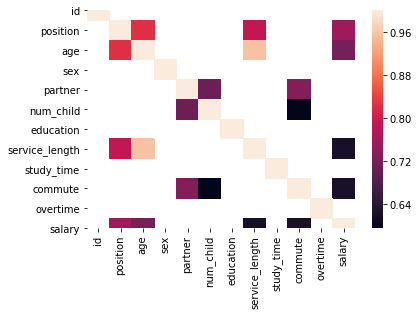

In [22]:
#plt.figure(figsize=(20, 20))
sns.heatmap(X.corr()[abs(X.corr())>0.5] , cbar=True)
#sns.heatmap(X.corr(), cbar=True, annot=True)
plt.show()

In [23]:
X.corr()['salary'].sort_values(ascending=False)

salary            1.000000
position          0.753490
age               0.718382
commute           0.623286
service_length    0.621291
education         0.454572
study_time        0.244490
num_child         0.171319
partner           0.144524
id                0.010266
sex              -0.029740
overtime         -0.036701
Name: salary, dtype: float64

## 目的変数とのabs相関の高い変数(0.5以上)
1. position - 0.753490
2. age - 0.718382
3. commute - 0.623286
4. service_length - 0.621291

# position
役職（0=役職なし, 1=主任, 2=係長, 3=課長, 4=部長）

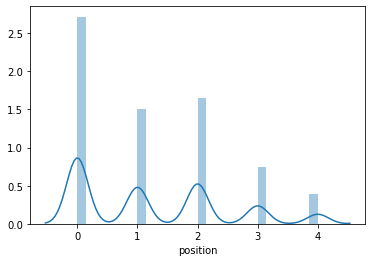

In [24]:
position = X['position']
sns.distplot(position);

In [25]:
position.value_counts()

0    8149
2    4939
1    4515
3    2217
4    1180
Name: position, dtype: int64

In [26]:
X.groupby('position')['salary'].mean()

position
0    221.397176
1    351.982230
2    462.109367
3    522.594037
4    635.816707
Name: salary, dtype: float64

In [27]:
X.corr()[abs(X.corr()['position']) > 0.5]['position']

position          1.000000
age               0.824020
service_length    0.788785
salary            0.753490
Name: position, dtype: float64

## まとめ
役職が高い人は、"年が高い"・"残業が長い"・"給与が高い"傾向がある。

# age
年齢（歳）

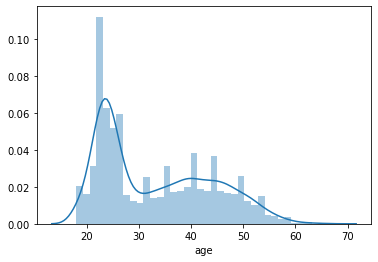

In [28]:
sns.distplot(X['age']);

In [63]:
X.groupby(['sex', 'age'])['salary'].count()

sex  age
1    18     172
     19     104
     20     223
     21     454
     22     690
     23     870
     24     855
     25     681
     26     515
     27     309
     28     217
     29     178
     30     155
     31     156
     32     166
     33     205
     34     197
     35     222
     36     224
     37     235
     38     245
     39     268
     40     256
     41     242
     42     255
     43     262
     44     240
     45     224
     46     228
     47     206
     48     210
     49     180
     50     156
     51     155
     52     149
     53     100
     54      81
     55      62
     56      54
     57      37
     58      36
     59      22
     60      10
     61       7
     62       8
     63       6
     64       2
     65       5
     66       1
2    18     164
     19     117
     20     208
     21     388
     22     633
     23     837
     24     834
     25     720
     26     472
     27     316
     28     199
     29     157
     30     147

(172,)


# area

In [29]:
X['area'].head()

0     愛知県
1     奈良県
2     山口県
3     東京都
4    鹿児島県
Name: area, dtype: object

In [30]:
X['area'].value_counts()

鹿児島県    492
三重県     486
岡山県     477
長崎県     472
沖縄県     471
東京都     470
京都府     469
奈良県     467
埼玉県     465
福島県     465
宮崎県     464
福岡県     463
和歌山県    462
群馬県     462
熊本県     462
愛媛県     457
石川県     456
佐賀県     455
広島県     453
山梨県     452
青森県     451
香川県     451
大分県     446
島根県     446
千葉県     445
岩手県     440
徳島県     438
新潟県     437
茨城県     437
神奈川県    437
岐阜県     435
栃木県     434
山口県     433
秋田県     432
富山県     431
福井県     431
鳥取県     429
長野県     428
大阪府     427
静岡県     426
滋賀県     426
宮城県     426
北海道     423
山形県     423
愛知県     423
兵庫県     418
高知県     407
Name: area, dtype: int64

In [31]:
X.groupby('area')['salary'].mean().sort_values(ascending=False)

area
東京都     409.596069
大阪府     404.067119
愛知県     384.661121
福岡県     377.680773
岐阜県     374.783402
群馬県     374.659085
滋賀県     372.962529
秋田県     371.160220
熊本県     370.048375
茨城県     366.557272
三重県     365.944746
富山県     365.825834
山梨県     365.226098
福島県     364.271705
佐賀県     364.043276
鳥取県     362.330501
青森県     362.324718
栃木県     362.270617
和歌山県    362.038188
奈良県     362.036901
宮城県     361.346471
山口県     359.697101
島根県     357.484139
神奈川県    357.461970
大分県     357.168997
長野県     356.602902
京都府     355.784066
宮崎県     355.519936
北海道     355.458201
広島県     355.141623
石川県     354.799094
愛媛県     354.154638
兵庫県     353.478069
鹿児島県    352.318505
新潟県     351.799265
長崎県     351.646007
岩手県     351.532641
福井県     351.469885
高知県     351.454481
徳島県     351.445603
千葉県     351.107276
岡山県     350.777185
香川県     350.713696
山形県     350.567906
埼玉県     349.922055
静岡県     349.548015
沖縄県     335.208222
Name: salary, dtype: float64

# sex


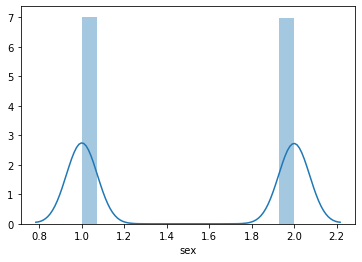

1    10535
2    10465
Name: sex, dtype: int64


In [32]:
col = 'sex'
sns.distplot(X[col])
plt.show()
print(X[col].value_counts())

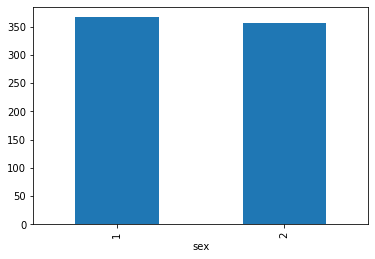

In [34]:
X.groupby(col)['salary'].mean().sort_values(ascending=False).plot.bar()

## 性別と役職

In [40]:
X.groupby(['sex', 'position'])['salary'].count()

sex  position
1    0           4112
     1           2315
     2           2467
     3           1071
     4            570
2    0           4037
     1           2200
     2           2472
     3           1146
     4            610
Name: salary, dtype: int64

In [36]:
X.groupby(['sex', 'position'])['salary'].mean()

sex  position
1    0           228.552222
     1           360.087364
     2           464.628596
     3           535.212717
     4           641.506211
2    0           214.109202
     1           343.453418
     2           459.595233
     3           510.801186
     4           630.500286
Name: salary, dtype: float64

## 平均給与で、男女差は無い

# num_child


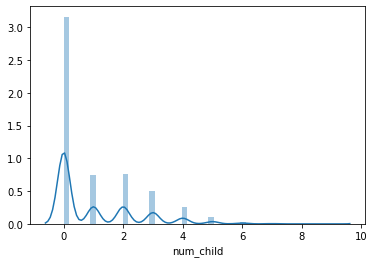

0    11947
2     2854
1     2817
3     1870
4      948
5      377
6      137
7       43
8        5
9        2
Name: num_child, dtype: int64
num_child
7    493.407032
6    451.391650
5    444.529636
8    434.533102
9    421.421379
4    419.339429
3    397.661301
2    386.638487
1    371.594381
0    338.119180
Name: salary, dtype: float64


In [93]:
col = 'num_child'
sns.distplot(X[col])
plt.show()
print(X[col].value_counts())
print(X.groupby(col)['salary'].mean().sort_values(ascending=False))

# education

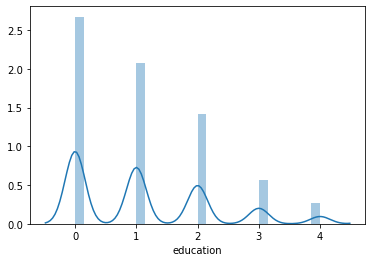

0    8019
1    6217
2    4247
3    1709
4     808
Name: education, dtype: int64
education
4    689.959198
3    513.527494
2    385.366883
1    325.703226
0    310.253471
Name: salary, dtype: float64


In [94]:
col = 'education'
sns.distplot(X[col])
plt.show()
print(X[col].value_counts())
print(X.groupby(col)['salary'].mean().sort_values(ascending=False))

# service_length


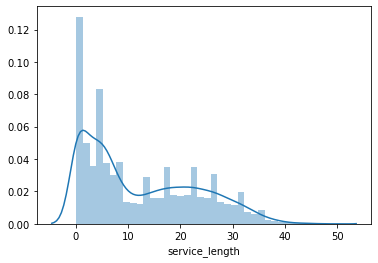

0     2617
2     1344
5     1163
4     1093
6     1011
3      971
1      845
7      814
8      573
19     488
21     485
23     484
18     479
22     471
20     470
17     465
9      461
24     451
25     436
26     435
16     432
15     427
14     410
27     395
13     372
28     366
10     358
11     357
12     330
29     328
30     308
31     289
32     239
33     204
34     164
35     132
36      95
37      67
38      53
39      39
40      24
42      15
41      12
45       9
44       8
43       7
47       3
49       1
Name: service_length, dtype: int64
service_length
49    663.390296
44    570.864443
43    553.755363
31    545.094192
42    539.273452
35    531.762347
30    531.732365
32    530.789197
29    529.196242
33    527.541124
34    527.029456
37    526.914513
39    524.176800
36    520.278145
28    516.141561
41    515.455797
38    512.228209
40    509.493169
27    501.981707
26    500.959757
25    500.061935
24    499.072783
45    498.576075
47    498.233044
23    494.8747

In [95]:
col = 'service_length'
sns.distplot(X[col])
plt.show()
print(X[col].value_counts())
print(X.groupby(col)['salary'].mean().sort_values(ascending=False))

# study_time

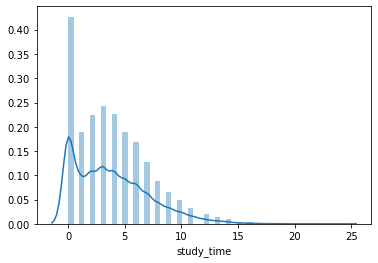

0.0     4300
3.0     2438
4.0     2285
2.0     2257
5.0     1917
1.0     1914
6.0     1705
7.0     1284
8.0      883
9.0      671
10.0     487
11.0     328
12.0     201
13.0     133
14.0      96
15.0      40
16.0      29
17.0      14
18.0       8
19.0       4
20.0       4
24.0       1
21.0       1
Name: study_time, dtype: int64
study_time
20.0    722.005866
24.0    701.928057
19.0    651.107785
18.0    637.161308
17.0    628.910502
15.0    615.598101
16.0    587.921529
14.0    573.266600
21.0    570.099073
13.0    543.051003
12.0    493.774722
11.0    493.494859
10.0    466.163895
9.0     446.106037
8.0     413.085505
7.0     399.140151
6.0     369.070437
5.0     359.840382
0.0     350.985305
4.0     345.783625
3.0     321.204021
2.0     320.302593
1.0     316.512200
Name: salary, dtype: float64


In [96]:
col = 'study_time'
sns.distplot(X[col])
plt.show()
print(X[col].value_counts())
print(X.groupby(col)['salary'].mean().sort_values(ascending=False))

# commute


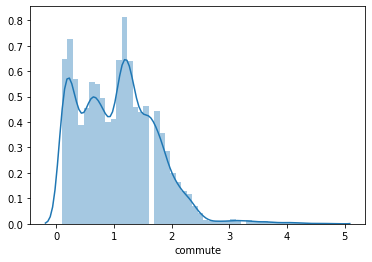

In [97]:
col = 'commute'
sns.distplot(X[col])
plt.show()

In [98]:
print(X[col].value_counts())

1.2    1607
0.2    1433
0.1    1280
1.1    1272
1.3    1263
0.3    1121
0.6    1098
0.7    1087
0.8     973
1.6     918
1.4     906
0.5     902
1.7     877
1.5     870
1.0     816
0.9     792
0.4     763
1.8     708
1.9     567
2.0     391
2.1     326
2.2     253
2.3     231
2.4     137
2.5      83
3.1      35
3.3      30
2.6      29
2.9      22
2.8      21
3.2      20
3.0      20
2.7      19
3.6      19
3.4      17
3.7      15
3.5      15
4.0      13
3.8      11
4.1       9
4.2       8
4.3       6
3.9       6
4.5       5
4.6       3
4.7       2
4.8       1
Name: commute, dtype: int64


In [99]:
print(X.groupby(col)['salary'].mean())

commute
0.1     181.388535
0.2     186.251574
0.3     197.035577
0.4     235.628761
0.5     276.714629
0.6     309.699232
0.7     342.395935
0.8     386.175957
0.9     438.184835
1.0     422.921348
1.1     360.618985
1.2     352.061248
1.3     367.645056
1.4     378.696641
1.5     389.639900
1.6     410.032276
1.7     443.587223
1.8     494.410122
1.9     534.104183
2.0     568.968446
2.1     633.714997
2.2     674.212206
2.3     690.180591
2.4     678.004242
2.5     544.422478
2.6     560.690409
2.7     513.181019
2.8     493.420741
2.9     393.102990
3.0     388.334842
3.1     413.041105
3.2     456.159256
3.3     497.262074
3.4     481.378378
3.5     533.163440
3.6     585.505397
3.7     599.802643
3.8     584.301804
3.9     585.757073
4.0     623.636692
4.1     574.143539
4.2     605.957661
4.3     691.416333
4.5     760.405916
4.6     863.502342
4.7     782.371028
4.8    1012.249230
Name: salary, dtype: float64


# Groupby

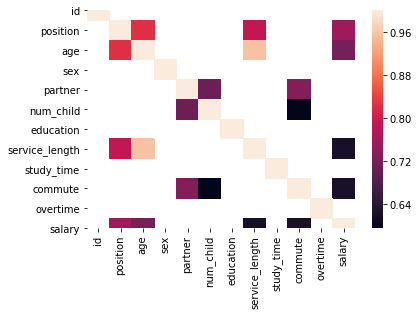

In [100]:
#plt.figure(figsize=(20, 20))
sns.heatmap(X.corr()[abs(X.corr())>0.5] , cbar=True)
#sns.heatmap(X.corr(), cbar=True, annot=True)
plt.show()

1. position - age
2. position - service_length
3. age - service_length
4. partner - num_child
5. partner - commute
6. num_child - commute
7. service_length - age

## 役職と年齢

In [101]:
A = 'position' 
B = 'age'
group_min = X[B].min()
group_max = X[B].max()
group_lin = np.linspace(group_min, group_max, (group_max-group_min)+1)

group_df = pd.DataFrame({B:group_lin})

for i in X[A].unique():
    group_df[f'{A}_{i}'] = group_df[B]
    
    group_df[f'{A}_{i}'] = group_df[f'{A}_{i}'].map(
        X.groupby([A, B])['salary'].mean()[i])
    
group_df.sort_index(axis=1)

,age,position_0,position_1,position_2,position_3,position_4
0,18.0,204.288484,279.859311,338.813532,NaN,NaN
1,19.0,204.174923,281.090892,303.849773,NaN,NaN
2,20.0,206.198108,282.675801,307.718527,NaN,NaN
3,21.0,214.241101,304.186061,310.073062,NaN,NaN
4,22.0,213.906630,307.600939,365.705272,NaN,NaN
5,23.0,219.330908,312.634900,379.666332,353.043465,NaN
6,24.0,222.610760,312.059399,386.845058,NaN,NaN
7,25.0,225.799919,334.901577,367.256359,NaN,NaN
8,26.0,233.975355,333.765839,424.999633,545.670127,NaN
9,27.0,239.774768,327.045724,386.452650,470.471409,NaN


## 66歳以上は削除

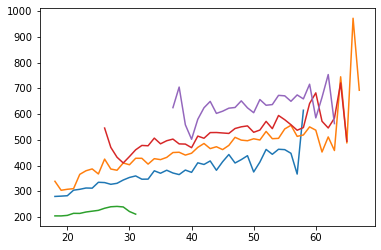

In [102]:
for i in group_df.columns:
    if i == 'age':
        pass
    else:
        plt.plot(group_df['age'], group_df[i])
plt.show()

## grouping

In [115]:
X['position_age'] = 0
X['position_age'][(X['age'] >=18) & (X['age'] <=25)] = 0
X['position_age'][(X['age'] >=26) & (X['age'] <=31)] = 1
X['position_age'][(X['age'] >=32) & (X['age'] <=36)] = 2
X['position_age'][(X['age'] >=37)& (X['age'] <=58)] = 3
X['position_age'][(X['age'] >=59)] = 4